<a href="https://colab.research.google.com/github/xinruili07/MiniProject1/blob/master/mini_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import math
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
cases_df = pd.read_csv("/content/drive/My Drive/Project1/aggregated_cc_by.csv")
trends_df = pd.read_csv("/content/drive/My Drive/Project1/2020_US_weekly_symptoms_dataset.csv")

cases_df.shape
trends_df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,date,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,symptom:Allergic conjunctivitis,symptom:Allergy,symptom:Amblyopia,symptom:Amenorrhea,symptom:Amnesia,symptom:Anal fissure,symptom:Anaphylaxis,symptom:Anemia,symptom:Angina pectoris,symptom:Angioedema,symptom:Angular cheilitis,symptom:Anosmia,symptom:Anxiety,symptom:Aphasia,symptom:Aphonia,symptom:Apnea,symptom:Arthralgia,symptom:Arthritis,symptom:Ascites,symptom:Asperger syndrome,symptom:Asphyxia,symptom:Asthma,symptom:Astigmatism,symptom:Ataxia,...,symptom:Throat irritation,symptom:Thrombocytopenia,symptom:Thyroid nodule,symptom:Tic,symptom:Tinnitus,symptom:Tonsillitis,symptom:Toothache,symptom:Tremor,symptom:Trichoptilosis,symptom:Tumor,symptom:Type 2 diabetes,symptom:Unconsciousness,symptom:Underweight,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary incontinence,symptom:Urinary tract infection,symptom:Urinary urgency,symptom:Uterine contraction,symptom:Vaginal bleeding,symptom:Vaginal discharge,symptom:Vaginitis,symptom:Varicose veins,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Ventricular tachycardia,symptom:Vertigo,symptom:Viral pneumonia,symptom:Visual acuity,symptom:Vomiting,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
0,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,12.69,NaN,NaN,NaN,NaN,NaN,12.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.31,NaN,NaN,NaN,...,NaN,NaN,15.86,NaN,NaN,NaN,NaN,NaN,11.90,NaN,NaN,NaN,NaN,18.84,13.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.08,9.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.28,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-13,NaN,NaN,NaN,NaN,NaN,9.56,NaN,NaN,NaN,NaN,NaN,12.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.20,NaN,NaN,NaN,...,NaN,NaN,12.24,NaN,NaN,NaN,NaN,NaN,7.84,NaN,NaN,NaN,NaN,16.83,13.01,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,15.30,8.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.26,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.90,NaN,NaN,NaN,...,NaN,NaN,17.66,NaN,NaN,NaN,NaN,NaN,15.27,NaN,NaN,NaN,NaN,18.40,12.14,NaN,NaN,7.54,NaN,NaN,NaN,NaN,NaN,10.30,16.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.48,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-27,NaN,NaN,NaN,NaN,NaN,15.31,7.47,NaN,NaN,NaN,NaN,15.67,NaN,NaN,NaN,NaN,NaN,NaN,7.47,NaN,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,12.03,NaN,NaN,NaN,...,NaN,NaN,12.76,NaN,NaN,NaN,NaN,NaN,9.84,NaN,NaN,NaN,NaN,20.41,17.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.93,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-02-03,NaN,NaN,NaN,NaN,NaN,8.81,NaN,NaN,NaN,NaN,NaN,13.87,NaN,NaN,NaN,NaN,NaN,NaN,8.06,NaN,NaN,NaN,12.56,NaN,NaN,NaN,NaN,NaN,14.24,NaN,NaN,NaN,...,NaN,NaN,16.68,NaN,NaN,NaN,NaN,NaN,10.68,NaN,NaN,NaN,NaN,20.62,16.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.24,10.68,NaN,NaN,10.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.93,NaN,NaN


In [9]:
# 1. NORMALIZATION AND STANDARDIZATION FUNCTIONS

def de_mean_trends(df, standard=False):
  for column in df.columns:
    if column.startswith('symptom:'):
      df[column] = df[column] - df[column].mean()
      if standard:
        df[column] = df[column]/df[column].std()

def de_median_trends(df):
  for column in df.columns:
    if column.startswith('symptom:'):
      df[column] = df[column] - df[column].median()

de_mean_trends(trends_df)
trends_df.head()

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,date,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,symptom:Allergic conjunctivitis,symptom:Allergy,symptom:Amblyopia,symptom:Amenorrhea,symptom:Amnesia,symptom:Anal fissure,symptom:Anaphylaxis,symptom:Anemia,symptom:Angina pectoris,symptom:Angioedema,symptom:Angular cheilitis,symptom:Anosmia,symptom:Anxiety,symptom:Aphasia,symptom:Aphonia,symptom:Apnea,symptom:Arthralgia,symptom:Arthritis,symptom:Ascites,symptom:Asperger syndrome,symptom:Asphyxia,symptom:Asthma,symptom:Astigmatism,symptom:Ataxia,...,symptom:Throat irritation,symptom:Thrombocytopenia,symptom:Thyroid nodule,symptom:Tic,symptom:Tinnitus,symptom:Tonsillitis,symptom:Toothache,symptom:Tremor,symptom:Trichoptilosis,symptom:Tumor,symptom:Type 2 diabetes,symptom:Unconsciousness,symptom:Underweight,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary incontinence,symptom:Urinary tract infection,symptom:Urinary urgency,symptom:Uterine contraction,symptom:Vaginal bleeding,symptom:Vaginal discharge,symptom:Vaginitis,symptom:Varicose veins,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Ventricular tachycardia,symptom:Vertigo,symptom:Viral pneumonia,symptom:Visual acuity,symptom:Vomiting,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
0,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,1.863435,NaN,NaN,NaN,NaN,NaN,1.815566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.285223,NaN,NaN,NaN,...,NaN,NaN,5.047166,NaN,NaN,NaN,NaN,NaN,2.294484,NaN,NaN,NaN,NaN,4.538966,4.084677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.128356,-1.5958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0148,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-13,NaN,NaN,NaN,NaN,NaN,-1.266565,NaN,NaN,NaN,NaN,NaN,2.145566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.395223,NaN,NaN,NaN,...,NaN,NaN,1.427166,NaN,NaN,NaN,NaN,NaN,-1.765516,NaN,NaN,NaN,NaN,2.528966,3.214677,NaN,NaN,-2.796205,NaN,NaN,NaN,NaN,NaN,7.348356,-3.0958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9948,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.695566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.106723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.304777,NaN,NaN,NaN,...,NaN,NaN,6.847166,NaN,NaN,NaN,NaN,NaN,5.664484,NaN,NaN,NaN,NaN,4.098966,2.344677,NaN,NaN,-2.906205,NaN,NaN,NaN,NaN,NaN,2.348356,4.6842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.2148,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-27,NaN,NaN,NaN,NaN,NaN,4.483435,-2.166008,NaN,NaN,NaN,NaN,5.195566,NaN,NaN,NaN,NaN,NaN,NaN,-5.255616,NaN,NaN,NaN,-9.494261,NaN,NaN,NaN,NaN,NaN,-1.565223,NaN,NaN,NaN,...,NaN,NaN,1.947166,NaN,NaN,NaN,NaN,NaN,0.234484,NaN,NaN,NaN,NaN,6.108966,7.694677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.348356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6648,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-02-03,NaN,NaN,NaN,NaN,NaN,-2.016565,NaN,NaN,NaN,NaN,NaN,3.395566,NaN,NaN,NaN,NaN,NaN,NaN,-4.665616,NaN,NaN,NaN,-4.584261,NaN,NaN,NaN,NaN,NaN,0.644777,NaN,NaN,NaN,...,NaN,NaN,5.867166,NaN,NaN,NaN,NaN,NaN,1.074484,NaN,NaN,NaN,NaN,6.318966,7.074677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.288356,-0.8258,NaN,NaN,-9.441872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.6648,NaN,NaN


In [10]:
us_states = trends_df.open_covid_region_code.unique()

# us_cases = cases_df[cases_df['open_covid_region_code'].isin(us_states)]
us_cases = cases_df[cases_df['open_covid_region_code'].str.startswith('US-')]

us_cases = us_cases[['open_covid_region_code', 'date', 'hospitalized_new', 'cases_new']]
print(us_cases.shape)


# us_cases['open_covid_region_code'].unique()
print(us_cases['cases_new'])
us_cases['hospitalized_new'].sum()


(11858, 4)
78164   NaN
78165   NaN
78166   NaN
78167   NaN
78168   NaN
         ..
90017   NaN
90018   NaN
90019   NaN
90020   NaN
90021   NaN
Name: cases_new, Length: 11858, dtype: float64


410405.0

In [11]:
trends_df.head()

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,date,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,symptom:Allergic conjunctivitis,symptom:Allergy,symptom:Amblyopia,symptom:Amenorrhea,symptom:Amnesia,symptom:Anal fissure,symptom:Anaphylaxis,symptom:Anemia,symptom:Angina pectoris,symptom:Angioedema,symptom:Angular cheilitis,symptom:Anosmia,symptom:Anxiety,symptom:Aphasia,symptom:Aphonia,symptom:Apnea,symptom:Arthralgia,symptom:Arthritis,symptom:Ascites,symptom:Asperger syndrome,symptom:Asphyxia,symptom:Asthma,symptom:Astigmatism,symptom:Ataxia,...,symptom:Throat irritation,symptom:Thrombocytopenia,symptom:Thyroid nodule,symptom:Tic,symptom:Tinnitus,symptom:Tonsillitis,symptom:Toothache,symptom:Tremor,symptom:Trichoptilosis,symptom:Tumor,symptom:Type 2 diabetes,symptom:Unconsciousness,symptom:Underweight,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary incontinence,symptom:Urinary tract infection,symptom:Urinary urgency,symptom:Uterine contraction,symptom:Vaginal bleeding,symptom:Vaginal discharge,symptom:Vaginitis,symptom:Varicose veins,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Ventricular tachycardia,symptom:Vertigo,symptom:Viral pneumonia,symptom:Visual acuity,symptom:Vomiting,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
0,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,1.863435,NaN,NaN,NaN,NaN,NaN,1.815566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.285223,NaN,NaN,NaN,...,NaN,NaN,5.047166,NaN,NaN,NaN,NaN,NaN,2.294484,NaN,NaN,NaN,NaN,4.538966,4.084677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.128356,-1.5958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0148,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-13,NaN,NaN,NaN,NaN,NaN,-1.266565,NaN,NaN,NaN,NaN,NaN,2.145566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.395223,NaN,NaN,NaN,...,NaN,NaN,1.427166,NaN,NaN,NaN,NaN,NaN,-1.765516,NaN,NaN,NaN,NaN,2.528966,3.214677,NaN,NaN,-2.796205,NaN,NaN,NaN,NaN,NaN,7.348356,-3.0958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9948,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.695566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.106723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.304777,NaN,NaN,NaN,...,NaN,NaN,6.847166,NaN,NaN,NaN,NaN,NaN,5.664484,NaN,NaN,NaN,NaN,4.098966,2.344677,NaN,NaN,-2.906205,NaN,NaN,NaN,NaN,NaN,2.348356,4.6842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.2148,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-27,NaN,NaN,NaN,NaN,NaN,4.483435,-2.166008,NaN,NaN,NaN,NaN,5.195566,NaN,NaN,NaN,NaN,NaN,NaN,-5.255616,NaN,NaN,NaN,-9.494261,NaN,NaN,NaN,NaN,NaN,-1.565223,NaN,NaN,NaN,...,NaN,NaN,1.947166,NaN,NaN,NaN,NaN,NaN,0.234484,NaN,NaN,NaN,NaN,6.108966,7.694677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.348356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6648,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-02-03,NaN,NaN,NaN,NaN,NaN,-2.016565,NaN,NaN,NaN,NaN,NaN,3.395566,NaN,NaN,NaN,NaN,NaN,NaN,-4.665616,NaN,NaN,NaN,-4.584261,NaN,NaN,NaN,NaN,NaN,0.644777,NaN,NaN,NaN,...,NaN,NaN,5.867166,NaN,NaN,NaN,NaN,NaN,1.074484,NaN,NaN,NaN,NaN,6.318966,7.074677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.288356,-0.8258,NaN,NaN,-9.441872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.6648,NaN,NaN


In [12]:
# Getting all us states
us_states = trends_df.open_covid_region_code.unique()
print(us_states)

['US-AK' 'US-DC' 'US-DE' 'US-HI' 'US-ID' 'US-ME' 'US-MT' 'US-ND' 'US-NE'
 'US-NH' 'US-NM' 'US-RI' 'US-SD' 'US-VT' 'US-WV' 'US-WY']


In [13]:
us_cases = cases_df[cases_df['open_covid_region_code'].isin(us_states)]
us_cases = us_cases.reset_index(drop = True)
us_cases = us_cases[['open_covid_region_code', 'region_name', 'date', 'hospitalized_new']]
print(us_cases[:100])

us_cases.open_covid_region_code.unique()

   open_covid_region_code region_name        date  hospitalized_new
0                   US-WY     Wyoming  2020-03-07               0.0
1                   US-WY     Wyoming  2020-03-08               0.0
2                   US-WY     Wyoming  2020-03-09               0.0
3                   US-WY     Wyoming  2020-03-10               0.0
4                   US-WY     Wyoming  2020-03-11               0.0
..                    ...         ...         ...               ...
95                  US-WY     Wyoming  2020-06-10               1.0
96                  US-WY     Wyoming  2020-06-11               0.0
97                  US-WY     Wyoming  2020-06-12               0.0
98                  US-WY     Wyoming  2020-06-13               1.0
99                  US-WY     Wyoming  2020-06-14               0.0

[100 rows x 4 columns]


array(['US-WY', 'US-WV', 'US-VT', 'US-SD', 'US-RI', 'US-NM', 'US-NH',
       'US-NE', 'US-ND', 'US-MT', 'US-ME', 'US-ID', 'US-HI', 'US-DE',
       'US-DC', 'US-AK'], dtype=object)

In [14]:
def clean_data(df):
  (rows, cols) = df.shape
  print(rows, cols)
  row_threshold = int(rows * 0.05)
  col_threshold = int(cols * 0.05)

  df = df.dropna(axis = 0, thresh = col_threshold)
  df = df.dropna(axis = 1, thresh = row_threshold)
  df = df.reset_index(drop = True)
  (rows, cols) = df.shape
  print(rows, cols)
  return df

In [15]:
us_cases.columns
us_cases.head()

,open_covid_region_code,region_name,date,hospitalized_new
0,US-WY,Wyoming,2020-03-07,0.0
1,US-WY,Wyoming,2020-03-08,0.0
2,US-WY,Wyoming,2020-03-09,0.0
3,US-WY,Wyoming,2020-03-10,0.0
4,US-WY,Wyoming,2020-03-11,0.0


In [16]:
def group_data_by_weeks(df):
  df['date'] = pd.to_datetime(df['date']) - pd.to_timedelta(7, unit='d')
  df = df.groupby(['open_covid_region_code', pd.Grouper(key='date', freq='W-MON')])['hospitalized_new'].sum().reset_index().sort_values(['open_covid_region_code','date'])
  return df

us_cases = group_data_by_weeks(us_cases)
us_cases.head()

,open_covid_region_code,date,hospitalized_new
0,US-AK,2020-03-02,0.0
1,US-AK,2020-03-09,0.0
2,US-AK,2020-03-16,0.0
3,US-AK,2020-03-23,7.0
4,US-AK,2020-03-30,16.0


In [17]:
print("Before cleaning:")
print(trends_df.shape)

trends_df = clean_data(trends_df)

print("After cleaning:")
print(trends_df.shape)

Before cleaning:
(608, 430)
608 430
266 120
After cleaning:
(266, 120)


In [18]:
trends_df['date'] = pd.to_datetime(trends_df['date'])

complete_df = trends_df.merge(us_cases, how='inner', on=['open_covid_region_code', 'date'])
complete_df.head()

print(complete_df.open_covid_region_code.unique())

['US-AK' 'US-DE' 'US-MT' 'US-ND' 'US-SD' 'US-VT' 'US-WY']


In [19]:
avgdf = complete_df.groupby(['open_covid_region_code']).mean()
only_symptoms_df = avgdf.drop(['hospitalized_new'], axis = 1)
only_symptoms_df = pd.DataFrame(only_symptoms_df.columns.values[np.argsort(-only_symptoms_df.values, axis=1)[:, :4]], index=only_symptoms_df.index, columns = ['1st Max','2nd Max','3rd Max', '4th Max']).reset_index()

only_symptoms_df.head()

,open_covid_region_code,1st Max,2nd Max,3rd Max,4th Max
0,US-AK,symptom:Chancre,symptom:Yawn,symptom:Photopsia,symptom:Paranoia
1,US-DE,symptom:Photodermatitis,symptom:Anosmia,symptom:Ageusia,symptom:Stomach rumble
2,US-MT,symptom:Beau's lines,symptom:Balance disorder,symptom:Subdural hematoma,symptom:Photodermatitis
3,US-ND,symptom:Leukorrhea,symptom:Round ligament pain,symptom:Photodermatitis,symptom:Goitre
4,US-SD,symptom:Ageusia,symptom:Chorea,symptom:Anosmia,symptom:Splenomegaly


In [20]:
complete_df.head()

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Adrenal crisis,symptom:Ageusia,symptom:Allergic conjunctivitis,symptom:Amenorrhea,symptom:Angular cheilitis,symptom:Anosmia,symptom:Aphonia,symptom:Asphyxia,symptom:Atheroma,symptom:Auditory hallucination,symptom:Balance disorder,symptom:Beau's lines,symptom:Bleeding on probing,symptom:Burning Chest Pain,symptom:Burning mouth syndrome,symptom:Cataplexy,symptom:Chancre,symptom:Chorea,symptom:Cleft lip and cleft palate,symptom:Clouding of consciousness,symptom:Crackles,symptom:Crepitus,symptom:Croup,symptom:Cyanosis,symptom:Depersonalization,symptom:Developmental disability,symptom:Dysautonomia,symptom:Dysgeusia,symptom:Dyspareunia,symptom:Dystonia,symptom:Dysuria,symptom:Epiphora,symptom:Esophagitis,symptom:Eye pain,...,symptom:Osteopenia,symptom:Osteophyte,symptom:Papule,symptom:Paranoia,symptom:Pericarditis,symptom:Petechia,symptom:Photodermatitis,symptom:Photophobia,symptom:Photopsia,symptom:Polycythemia,symptom:Polydipsia,symptom:Polyuria,symptom:Ptosis,symptom:Pulmonary edema,symptom:Rectal pain,symptom:Rectal prolapse,symptom:Renal colic,symptom:Rheum,symptom:Round ligament pain,symptom:Rumination,symptom:Sensitivity to sound,symptom:Shallow breathing,symptom:Spasticity,symptom:Splenomegaly,symptom:Sputum,symptom:Stomach rumble,symptom:Stridor,symptom:Subdural hematoma,symptom:Tachypnea,symptom:Tenderness,symptom:Thyroid nodule,symptom:Trichoptilosis,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary urgency,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Viral pneumonia,symptom:Yawn,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,2020-03-02,3.793435,NaN,NaN,-0.504434,NaN,NaN,NaN,-1.135223,2.926455,-1.80219,1.886504,-0.828679,-0.122819,-2.826415,5.077733,2.136018,5.735702,-2.987477,-1.566637,-2.999456,NaN,3.723106,12.777907,3.129336,NaN,-3.636933,-4.574856,-2.833439,-0.132432,2.254974,1.711842,1.262184,-1.405496,5.536316,...,6.215273,2.502204,1.849912,3.996133,-1.602526,13.365649,NaN,2.34567,4.1644,2.962533,-1.00093,-0.355342,9.790712,-1.366183,-3.144409,2.316814,4.603067,0.937184,3.843642,-4.003251,1.363093,NaN,-1.055403,2.656543,4.781918,0.572996,0.726512,13.207207,4.456295,-0.028717,8.617166,3.354484,7.458966,1.494677,NaN,5.338356,-1.0458,-5.821872,0.0348,0.0
1,US-AK,US,United States,Alaska,US-AK,2020-03-09,-0.226565,NaN,1.943921,2.315566,NaN,-5.396723,-9.234261,0.204777,3.606455,NaN,4.256504,3.161321,0.327181,NaN,0.907733,2.806018,5.145702,-3.697477,2.103363,NaN,NaN,NaN,15.377907,-0.580664,NaN,NaN,-2.784856,-2.553439,0.157568,0.264974,3.551842,-1.137816,2.574504,-0.643684,...,-0.284727,0.682204,1.009912,3.326133,NaN,7.455649,NaN,0.96567,1.8044,2.782533,NaN,-0.735342,2.300712,-3.096183,-4.214409,0.806814,5.123067,4.597184,1.343642,-2.403251,1.173093,-4.259403,NaN,1.316543,10.391918,NaN,2.236512,13.017207,0.596295,2.131283,0.297166,4.364484,32.648966,0.474677,NaN,1.308356,NaN,-1.091872,1.5048,0.0
2,US-AK,US,United States,Alaska,US-AK,2020-03-16,0.863435,NaN,-3.276079,NaN,NaN,3.123277,-9.194261,-2.525223,1.486455,NaN,-1.913496,-0.158679,1.657181,0.043585,-1.782267,-1.283982,4.715702,-3.107477,-2.676637,NaN,-4.096209,NaN,29.047907,1.129336,-1.382716,-5.766933,-3.814856,-1.923439,3.987568,-3.515026,1.581842,-1.537816,0.874504,-1.113684,...,NaN,-5.767796,-3.180088,1.336133,-1.272526,NaN,NaN,-0.81433,3.6744,1.772533,NaN,-2.345342,NaN,-1.626183,-3.954409,-0.403186,2.653067,2.357184,0.593642,0.866749,NaN,-1.429403,-0.915403,-1.753457,16.351918,1.252996,1.206512,-2.162793,-0.633705,0.391283,3.677166,-0.565516,64.408966,2.204677,NaN,3.578356,NaN,4.998128,5.0748,0.0
3,US-AK,US,United States,Alaska,US-AK,2020-03-23,0.323435,6.933992,NaN,-0.944434,NaN,32.703277,NaN,-4.205223,1.076455,-3.65219,-1.763496,1.021321,0.587181,4.613585,-1.552267,0.956018,1.305702,3.372523,-1.176637,NaN,-4.306209,NaN,18.007907,-0.360664,NaN,-8.836933,-5.354856,5.186561,-1.332432,-1.715026,1.891842,6.252184,-2.1

In [21]:
def classify_KMeans(complete_df):
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)
  X = complete_df.drop(complete_df.iloc[:, :9], axis = 1)
  X = X.drop(['hospitalized_new'], axis = 1)
  # X = X.drop(['region_name'], axis = 1)

  range_n_clusters = list(range(5, 40))

  best_average = 0
  best_K = 0

  for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_average:
      best_average = silhouette_avg
      best_k = n_clusters
  
  print("best number of clusters is: ", best_k)
  kmeans = KMeans(n_clusters=best_k)
  kmeans.fit(X)
  y_kmeans = kmeans.predict(X)
  X = TSNE(n_components=2).fit_transform(X)
  plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)
  centers = kmeans.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
  plt.show()

  print("best number of clusters is: ", 15)
  kmeans = KMeans(n_clusters=15)
  kmeans.fit(X)
  y_kmeans = kmeans.predict(X)
  X = TSNE(n_components=2).fit_transform(X)
  plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)
  centers = kmeans.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
  plt.show()

For n_clusters = 5 The average silhouette_score is : 0.15940436482644166
For n_clusters = 6 The average silhouette_score is : 0.17448040653230054
For n_clusters = 7 The average silhouette_score is : 0.18296244966260944
For n_clusters = 8 The average silhouette_score is : 0.150848175049638
For n_clusters = 9 The average silhouette_score is : 0.15797932075640334
For n_clusters = 10 The average silhouette_score is : 0.18304966719634708
For n_clusters = 11 The average silhouette_score is : 0.14991396719645267
For n_clusters = 12 The average silhouette_score is : 0.15516620074007484
For n_clusters = 13 The average silhouette_score is : 0.158668098674641
For n_clusters = 14 The average silhouette_score is : 0.1589202548418371
For n_clusters = 15 The average silhouette_score is : 0.15729984096310867
For n_clusters = 16 The average silhouette_score is : 0.15065266885886522
For n_clusters = 17 The average silhouette_score is : 0.1363896765384522
For n_clusters = 18 The average silhouette_score 

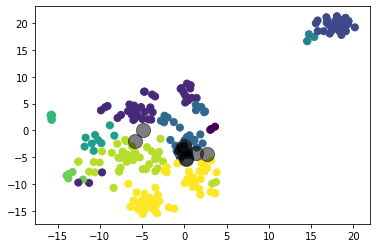

best number of clusters is:  15


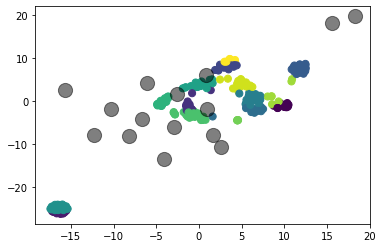

In [22]:
classify_KMeans(complete_df)

In [23]:
def plot_data(symptoms_df, complete_df):

  for index, row in symptoms_df.iterrows():
    region = symptoms_df.open_covid_region_code[index]
    region_df = complete_df.loc[complete_df['open_covid_region_code'] == region]
    region_df = region_df.reset_index(drop = True)
    n_bins = len(region_df)
    X = np.zeros([4, n_bins])
    f, ax = plt.subplots(1, 1)
    for i in range(4):
      # the symptom is actually offset by 1 in the column because of the first column, region code
      # check for each symptom out of top 4 symptom searched
      symptom = row.iloc[i + 1]
      j = 0
      for j, region_row in region_df.iterrows():
        X[i, j] = region_row[symptom]
      sns.regplot(list(range(0, n_bins)),X[i], lowess=True, label=symptom).set_title(region)
    ax.legend()
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From

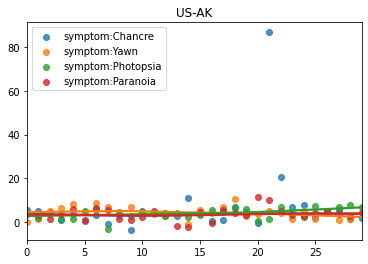

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

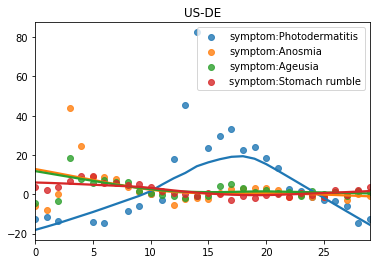

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

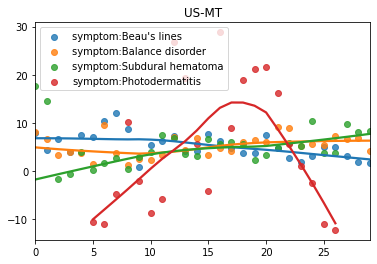

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

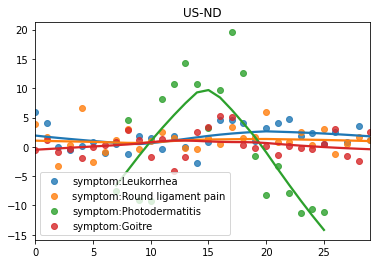

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

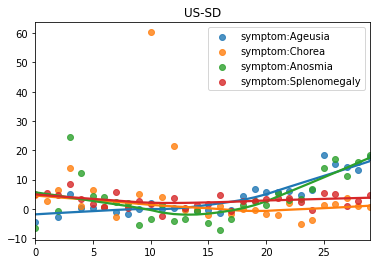

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

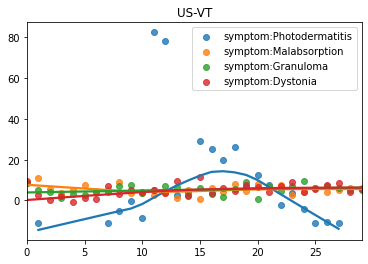

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

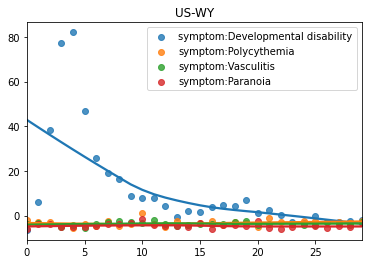

In [24]:
plot_data(only_symptoms_df,complete_df)


In [25]:
def knn_classifier(complete_df, split_type):
  
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)

  if split_type == 'region':
    splitted = complete_df.open_covid_region_code.unique()
    column = 'open_covid_region_code'
  else:
    splitted = complete_df.date.unique()
    column = 'date'

  splitted = np.array_split(np.array(splitted),5)
  print(splitted)
  for test_list in splitted:

    # there are 5 cv for 20-80 split
    train = complete_df[~complete_df[column].isin(test_list)]
    test = complete_df[complete_df[column].isin(test_list)]

    X_train = train.drop(train.iloc[:, :9], axis = 1)
    X_train = X_train.drop(['hospitalized_new'], axis = 1)
    # X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    X_test = test.drop(test.iloc[:, :9], axis = 1)
    X_test = X_test.drop(['hospitalized_new'], axis = 1)
    # X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']


    # k = 10
    # neighbhoor = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
    # Pred_y = neighbhoor.predict(X_test)
    # print("Accuracy of model at K=4 is",metrics.accuracy_score(Y_test, Pred_y))
    error_rate = []
    for i in range(1,41):
      if i % 2 == 0:
        continue
      knn = KNeighborsRegressor(n_neighbors=i)
      knn.fit(X_train,Y_train)
      pred_i = knn.predict(X_test)
      error_rate.append(np.mean((pred_i - Y_test)**2))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,21),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    if split_type == 'region':
      plt.title('By Region')
    else:
      plt.title('By Date ' + str(test_list[0]) +  ' to ' + str(test_list[-1]))
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at K =",error_rate.index(min(error_rate)))

[array(['US-AK', 'US-DE'], dtype=object), array(['US-MT', 'US-ND'], dtype=object), array(['US-SD'], dtype=object), array(['US-VT'], dtype=object), array(['US-WY'], dtype=object)]
Minimum error:  1366.2410146833222 at K = 19
Minimum error:  559.6200960219478 at K = 13
Minimum error:  2751.3421433267586 at K = 19
Minimum error:  627.2240705734089 at K = 11
Minimum error:  200.15312294543062 at K = 19


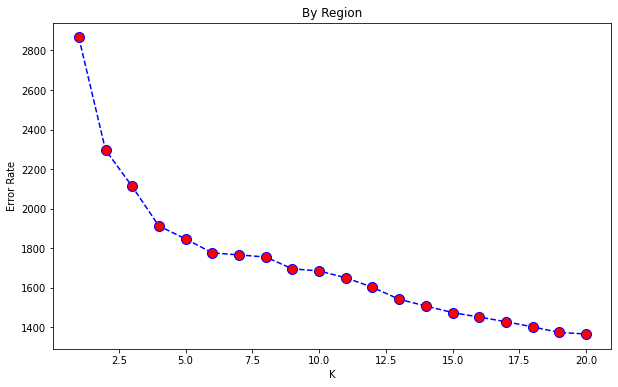

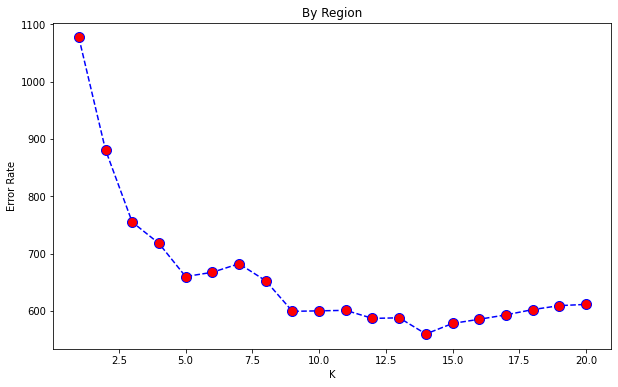

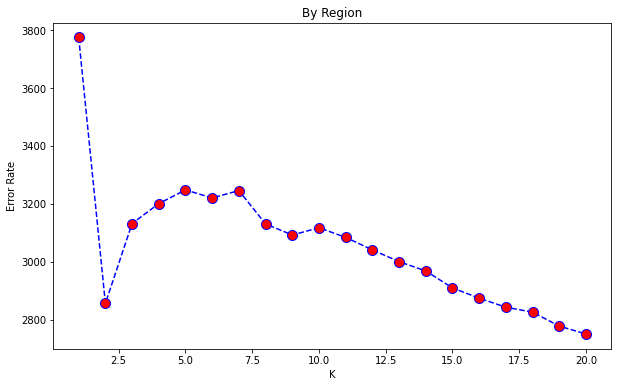

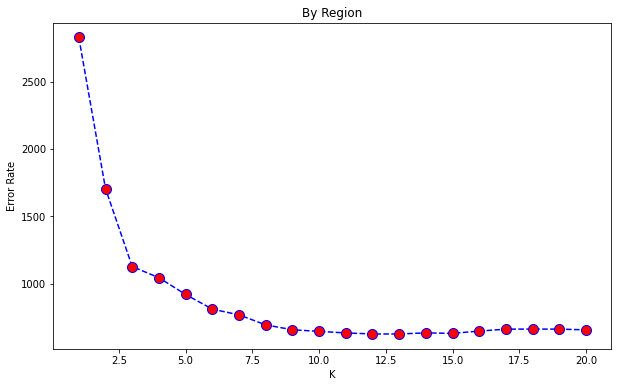

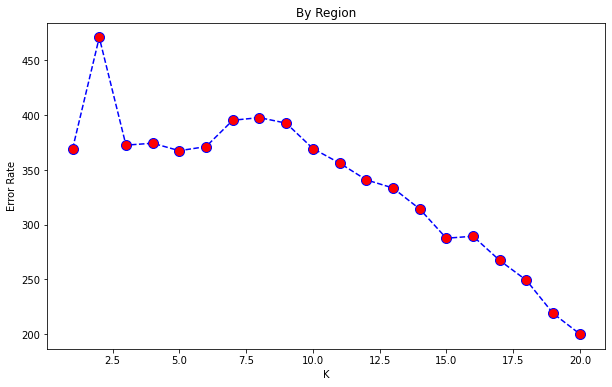

In [26]:
knn_classifier(complete_df, 'region')

[array(['2020-03-02T00:00:00.000000000', '2020-03-09T00:00:00.000000000',
       '2020-03-16T00:00:00.000000000', '2020-03-23T00:00:00.000000000',
       '2020-03-30T00:00:00.000000000', '2020-04-06T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-04-13T00:00:00.000000000', '2020-04-20T00:00:00.000000000',
       '2020-04-27T00:00:00.000000000', '2020-05-04T00:00:00.000000000',
       '2020-05-11T00:00:00.000000000', '2020-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-05-25T00:00:00.000000000', '2020-06-01T00:00:00.000000000',
       '2020-06-08T00:00:00.000000000', '2020-06-15T00:00:00.000000000',
       '2020-06-22T00:00:00.000000000', '2020-06-29T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-07-06T00:00:00.000000000', '2020-07-13T00:00:00.000000000',
       '2020-07-20T00:00:00.000000000', '2020-07-27T00:00:00.000000000',
       '2020-08-03T00:00:00.000000000', '2020-08-10T00:00:00.000000000'],
      dtype='datetime64[ns

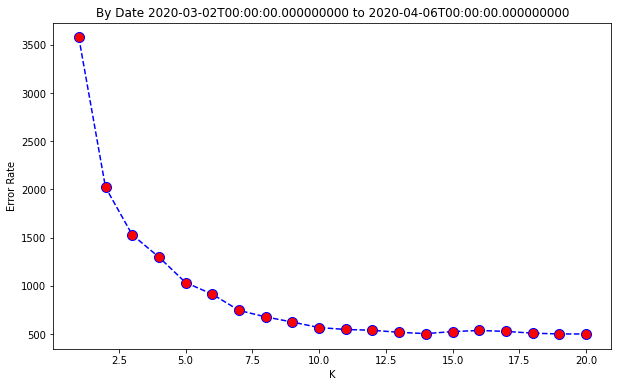

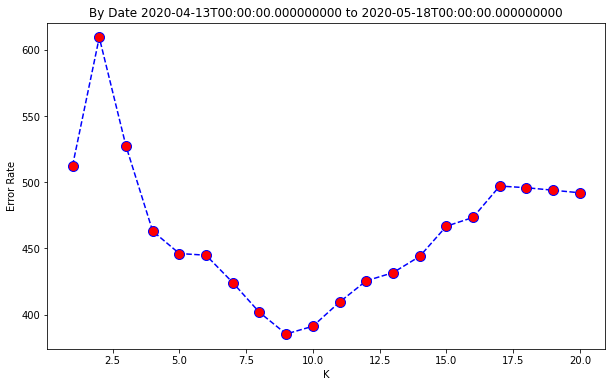

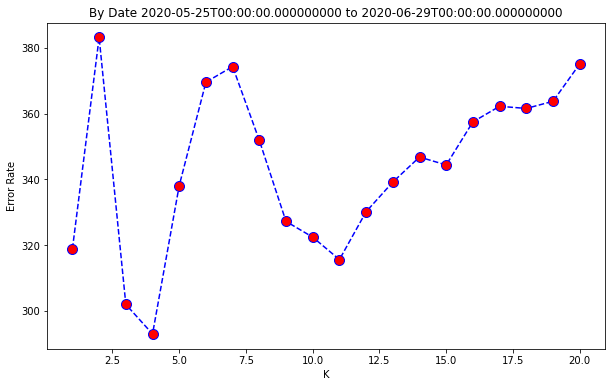

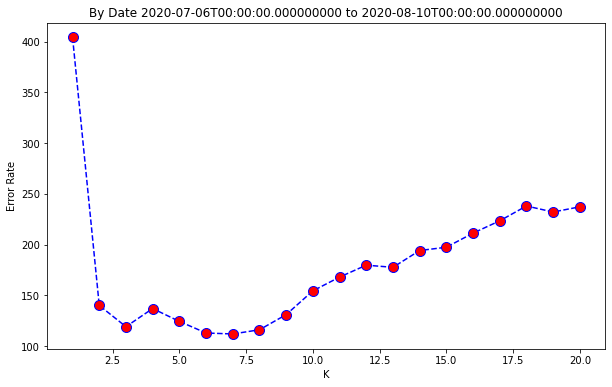

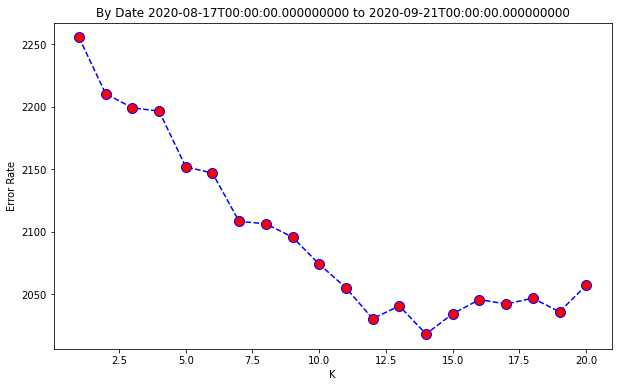

In [27]:
knn_classifier(complete_df, 'time')

In [28]:
def decisionTree_regressor(complete_df, split_type):
    
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)

  if split_type == 'region':
    splitted = complete_df.open_covid_region_code.unique()
    column = 'open_covid_region_code'
  else:
    splitted = complete_df.date.unique()
    column = 'date'

  splitted = np.array_split(np.array(splitted),5)
  print(splitted)
  for test_list in splitted:

    # there are 5 cv for 20-80 split
    train = complete_df[~complete_df[column].isin(test_list)]
    test = complete_df[complete_df[column].isin(test_list)]

    X_train = train.drop(train.iloc[:, :9], axis = 1)
    X_train = X_train.drop(['hospitalized_new'], axis = 1)
    # X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    print(test[column].unique())
    print(train[column].unique())
    X_test = test.drop(test.iloc[:, :9], axis = 1)
    X_test = X_test.drop(['hospitalized_new'], axis = 1)
    # X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']

    error_rate = []
    for i in range(1,40):
      dt = DecisionTreeRegressor(max_depth = i)
      dt.fit(X_train,Y_train)
      pred_i = dt.predict(X_test)
      error_rate.append(np.mean((pred_i - Y_test)**2))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    if split_type == 'region':
      plt.title(','.join(test_list))
    else:
      plt.title('By Date ' + str(test_list[0]) +  ' to ' + str(test_list[-1]))
    plt.xlabel('Depth')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at depth level =",error_rate.index(min(error_rate)))

[array(['US-AK', 'US-DE'], dtype=object), array(['US-MT', 'US-ND'], dtype=object), array(['US-SD'], dtype=object), array(['US-VT'], dtype=object), array(['US-WY'], dtype=object)]
['US-AK' 'US-DE']
['US-MT' 'US-ND' 'US-SD' 'US-VT' 'US-WY']
Minimum error:  272.38984904367015 at depth level = 2
['US-MT' 'US-ND']
['US-AK' 'US-DE' 'US-SD' 'US-VT' 'US-WY']
Minimum error:  763.8436781609196 at depth level = 0
['US-SD']
['US-AK' 'US-DE' 'US-MT' 'US-ND' 'US-VT' 'US-WY']
Minimum error:  2615.4666666666667 at depth level = 37
['US-VT']
['US-AK' 'US-DE' 'US-MT' 'US-ND' 'US-SD' 'US-WY']
Minimum error:  6689.128264807814 at depth level = 4
['US-WY']
['US-AK' 'US-DE' 'US-MT' 'US-ND' 'US-SD' 'US-VT']
Minimum error:  313.6004186136828 at depth level = 2


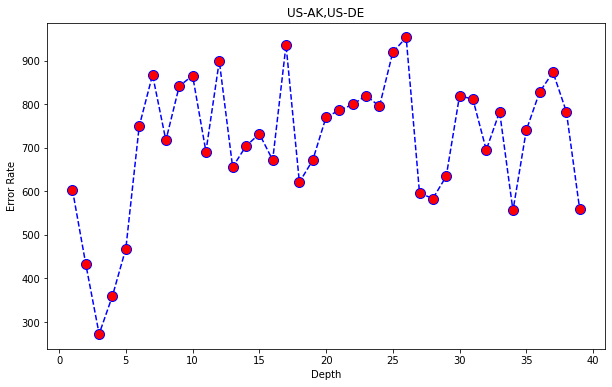

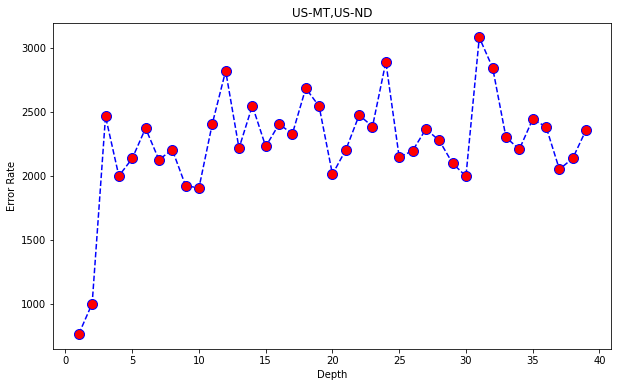

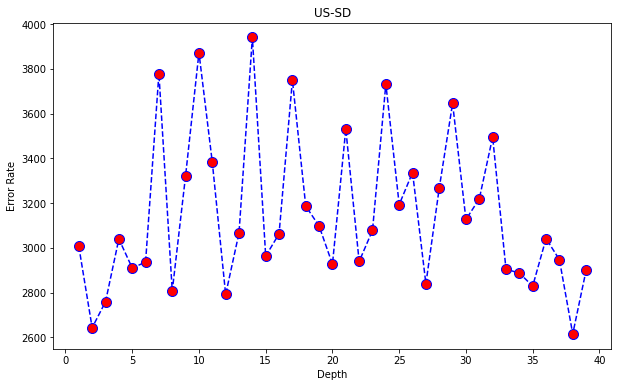

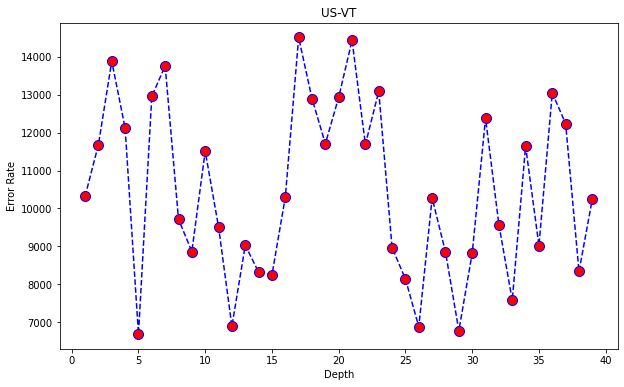

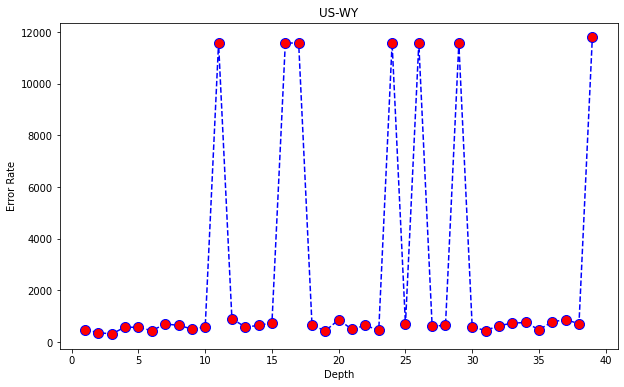

In [29]:
decisionTree_regressor(complete_df, 'region')

[array(['2020-03-02T00:00:00.000000000', '2020-03-09T00:00:00.000000000',
       '2020-03-16T00:00:00.000000000', '2020-03-23T00:00:00.000000000',
       '2020-03-30T00:00:00.000000000', '2020-04-06T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-04-13T00:00:00.000000000', '2020-04-20T00:00:00.000000000',
       '2020-04-27T00:00:00.000000000', '2020-05-04T00:00:00.000000000',
       '2020-05-11T00:00:00.000000000', '2020-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-05-25T00:00:00.000000000', '2020-06-01T00:00:00.000000000',
       '2020-06-08T00:00:00.000000000', '2020-06-15T00:00:00.000000000',
       '2020-06-22T00:00:00.000000000', '2020-06-29T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-07-06T00:00:00.000000000', '2020-07-13T00:00:00.000000000',
       '2020-07-20T00:00:00.000000000', '2020-07-27T00:00:00.000000000',
       '2020-08-03T00:00:00.000000000', '2020-08-10T00:00:00.000000000'],
      dtype='datetime64[ns

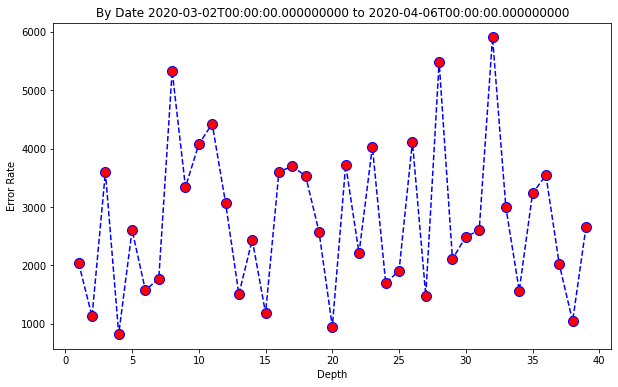

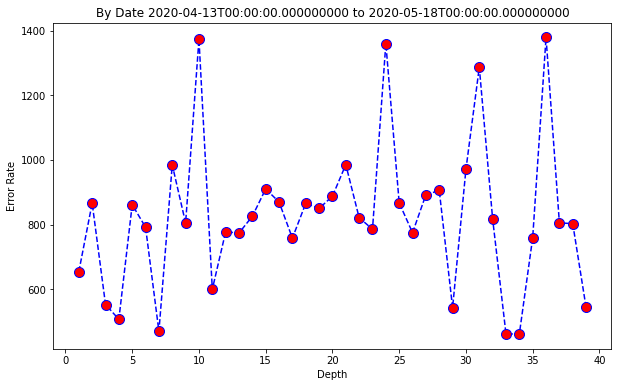

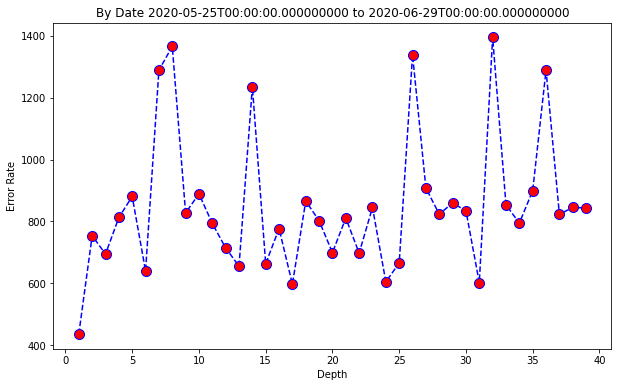

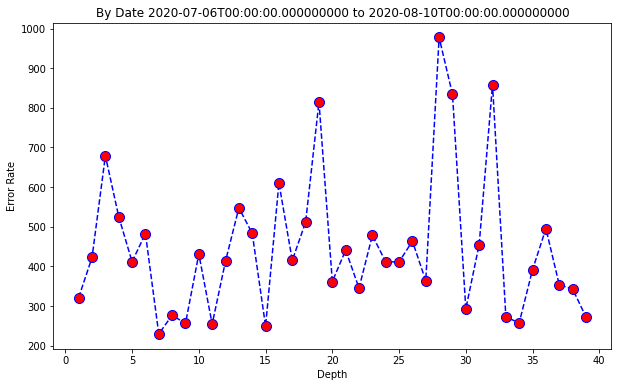

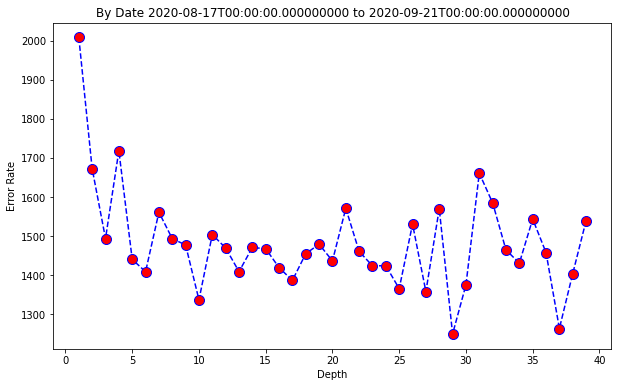

In [24]:
decisionTree_regressor(complete_df, 'time')